## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

## Load data

In [3]:
data_path='/Users/LuisFernandes/mlops-project/data/01_raw/predictive_maintenance.csv'
df = pd.read_csv(data_path)

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [8]:
df.shape

(10000, 10)

In [9]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


### <span style="color:black">Some observations from describe:</span>

- '<span style="background-color:lightgrey; color:black">Air Temperature</span>' has a mean of 300K and 75% of the data is distributed between 295.3K and 301.5K, seems like a realistic distribution.
- '<span style="background-color:lightgrey; color:black">Process temperature</span>' has a mean of 310K and the maximum data is distributed between 305.7K and 311.1K, seems like a realistic distribution.
- '<span style="background-color:lightgrey; color:black">Rotational speed</span>' has a mean of 1538, and 75% of the data is distributed between 1168 and 1612, but the maximum value is 2886, and it looks like investigation is needed to understand that maximum.
- '<span style="background-color:lightgrey; color:black">Torque</span>' has a mean of 39.9, the maximum value is 76.6, the minimum value is 1168, and the median is 40.1, which is slightly left-skewed from the mean.
- '<span style="background-color:lightgrey; color:black">Tool wear</span>' has a mean of 107.9, and the median (2nd quantile) is 108, which is almost a normal distribution.



In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [11]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

No null values found.

In [4]:
df.duplicated().sum()

0

No duplicated cells found

In [29]:
colors = ["#053F5E", "#116B85", "#1E97AF", "#2FBCD9", "#47E3FF", "#6AFFFF", "#9DFFFF"]
background_color = "white"



In [30]:
def show_correlation(data_frame):
    plt.figure(figsize=(10,10), facecolor=background_color)
    corr = data_frame.corr(numeric_only=False)
    sns.heatmap(corr, annot=True, cmap=colors[0:7][::-1])
    plt.title("Correlations", size=22, fontweight="bold")
    plt.tight_layout()

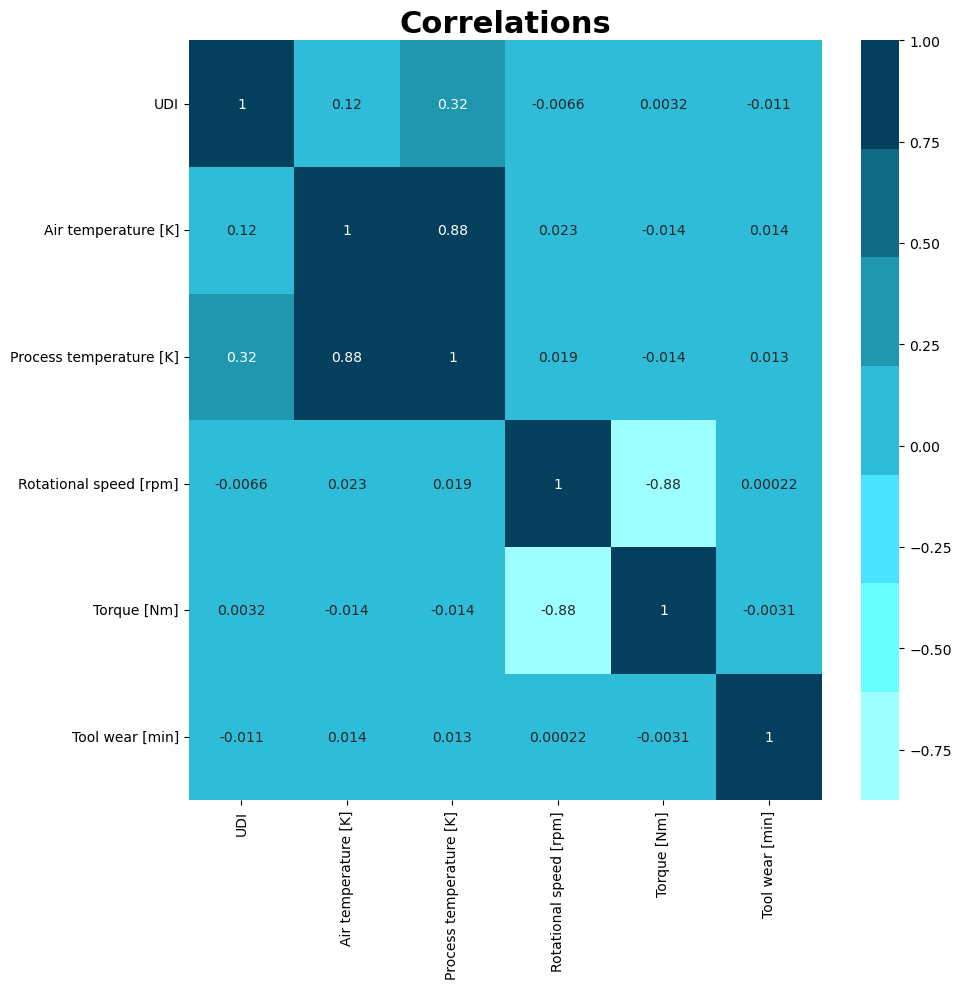

In [31]:
show_correlation(df.drop(["Product ID", "Type", "Target", "Failure Type"], axis=1))

We can observe there is a high correlation between Air Temperature and Process Temperature. Of course process temperature is always related with the air temperature, however in the occurrence of a fault is normal that the equipment get even hotter, therefore these features are not gonna be dropped, instead, the data_engineering pipeline (feature engineering) is gonna create a new variable of the difference between these two temperatures.


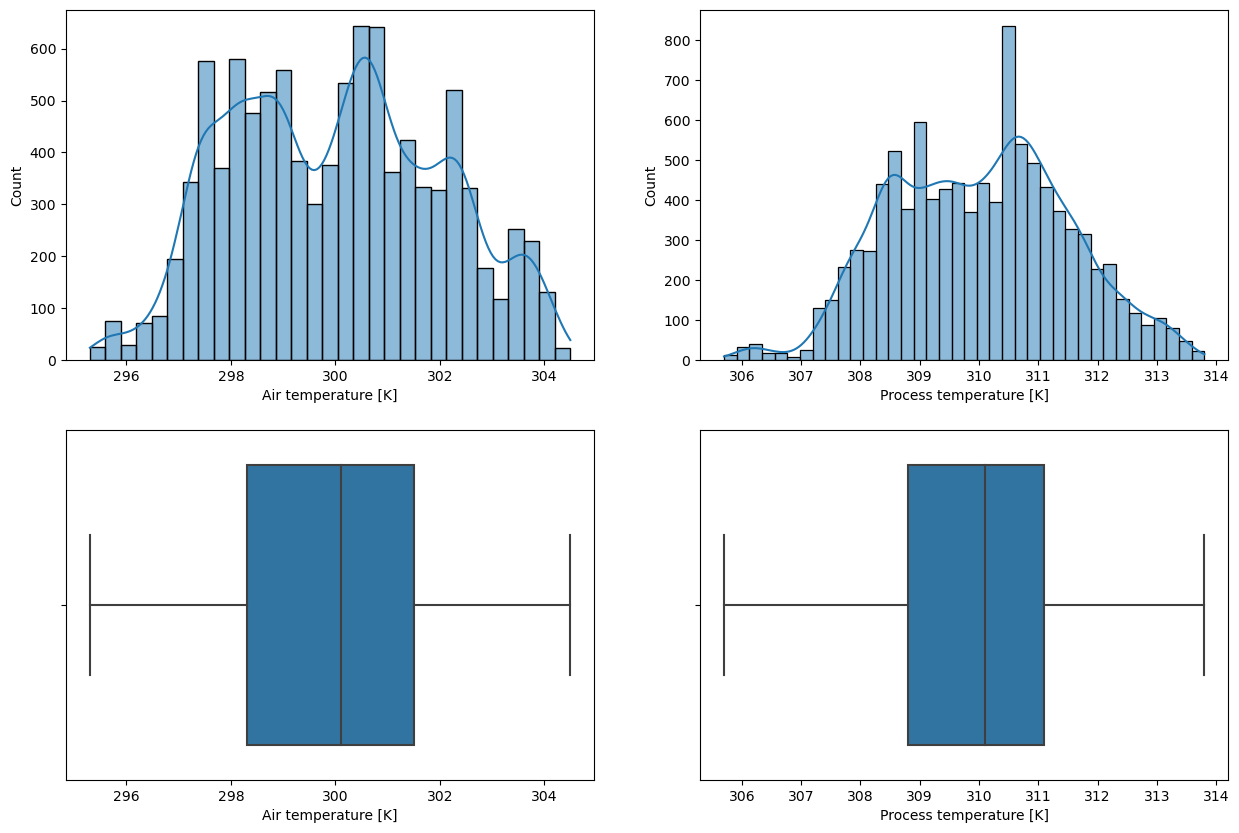

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
sns.histplot(data=df, x='Air temperature [K]', kde=True, ax=ax[0,0])
sns.histplot(data=df, x='Process temperature [K]', kde=True, ax=ax[0,1])
sns.boxplot(data=df, x='Air temperature [K]', ax=ax[1,0])
sns.boxplot(data=df, x='Process temperature [K]', ax=ax[1,1])
plt.show()

- Rotational speed and torque are also related. However both features are important for the study: The rotational speed might represent when the machine is working in a high demand or power (not necessarily faulty), and torque might represent the effort of the machine. Therefore torque is gonna be normalized, and rpm are gonna classify the machin as high-speed, medium-speed and low-speed within the data_engineering pipeline (feature engineering)

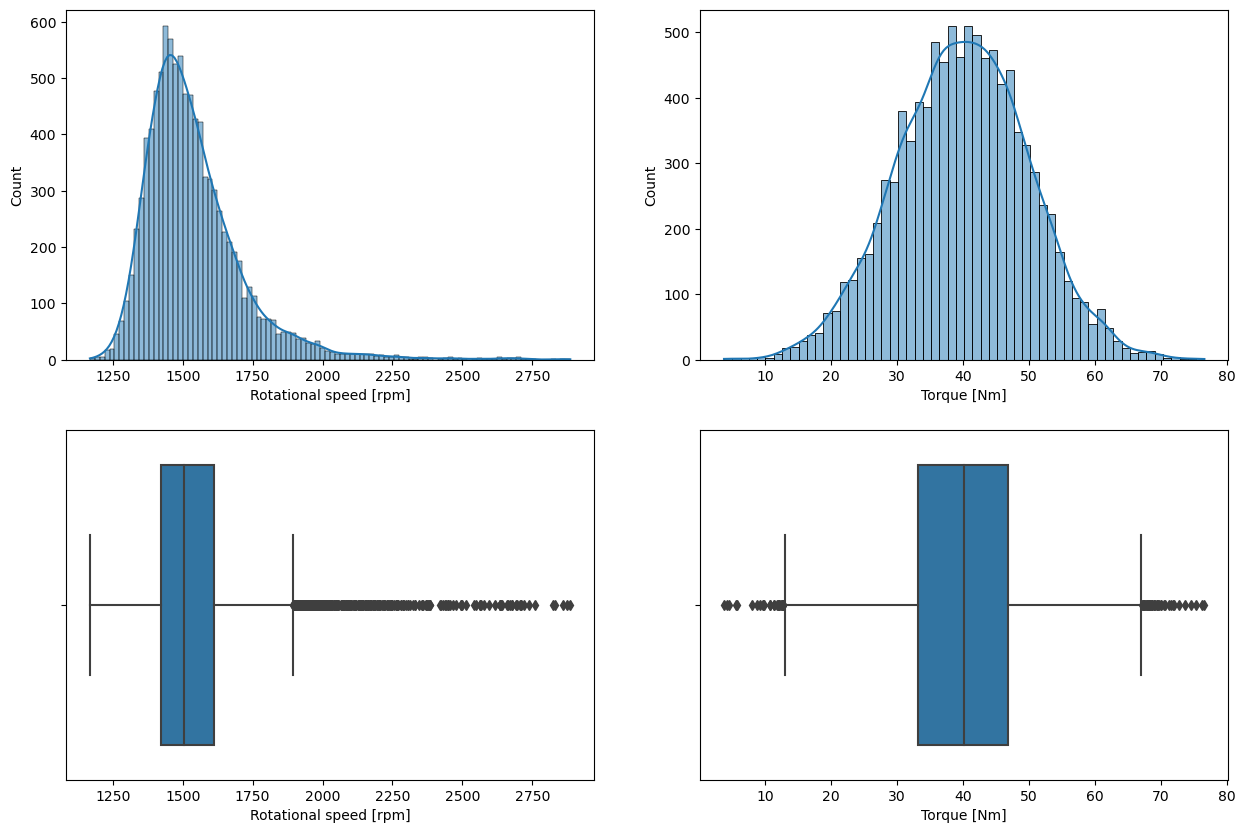

In [40]:
fig1, ax1 = plt.subplots(2, 2, figsize=(15,10))
sns.histplot(data=df, x='Rotational speed [rpm]', kde=True, ax=ax1[0,0])
sns.histplot(data=df, x='Torque [Nm]', kde=True, ax=ax1[0,1])
sns.boxplot(data=df, x='Rotational speed [rpm]', ax=ax1[1,0])
sns.boxplot(data=df, x='Torque [Nm]', ax=ax1[1,1])
plt.show()

In [32]:
def show_category_distribution(data_frame,label_name,colors,exclude=[],figsize=(10, 5),d=[1, 2],bg_color=background_color):
    
    label_dict = data_frame[label_name].value_counts().to_dict()
    for e in exclude:
        del label_dict[e]
    label_dict = OrderedDict(sorted(label_dict.items(), key=lambda label: label[1]))
    label_classes= label_dict.keys()
    label_values = label_dict.values()
    explode = (0,)*(data_frame[label_name].nunique() - len(exclude))
    
    fig, ax = plt.subplots(d[0], d[1], facecolor=bg_color, figsize=figsize)
    sns.countplot(data=data_frame,
                  x=label_name,
                  palette=colors,
                  edgecolor="black",
                  hatch="\\",
                  ax=ax[0],
                  linewidth=1,
                  order = data_frame[label_name].value_counts().index)
    ax[0].set_title(f"Distribution of \"{label_name}\"", size=14, fontweight="bold")
    ax[0].set_xlabel("Class", size=10, fontweight="bold")
    ax[0].set_ylabel("Frequency", size=10, fontweight="bold")
    ax[0].tick_params(axis="x", labelsize=9) 
    ax[0].tick_params(axis="y", labelsize=9)
    ax[0].bar_label(ax[0].containers[0], fmt="%.0f", color="black", fontsize=9)
    
    plt.pie(label_values,
            explode=explode,
            labels=label_classes,
            autopct="%1.2f%%",
            shadow=True,
            startangle=90,
            textprops={"fontsize": 8, "fontweight": "bold", "color": "black"},
            wedgeprops={"edgecolor": "black"},
            colors=colors,
            labeldistance=1.1)
    plt.title(f"Distribution \n of \"{label_name}\". {','.join(exclude)} {'Excluded' if len(exclude)>0 else ''}",
              fontweight="bold",
              fontsize=14)

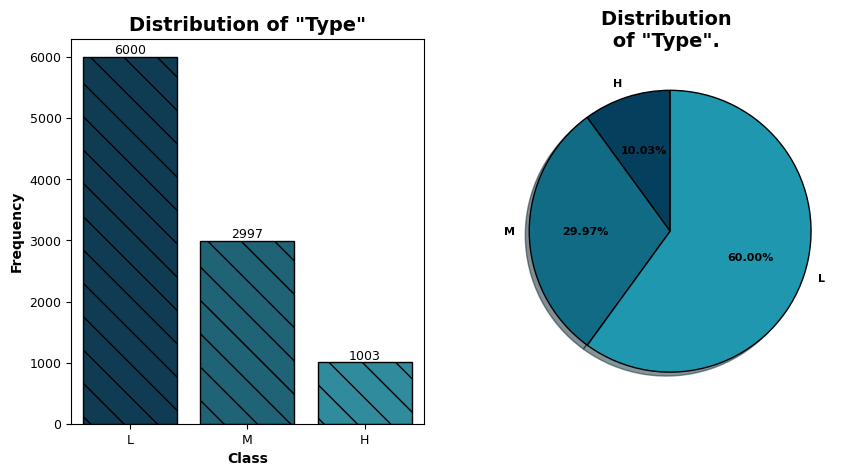

In [33]:
show_category_distribution(df,
                        "Type",
                        colors,
                        bg_color=background_color)

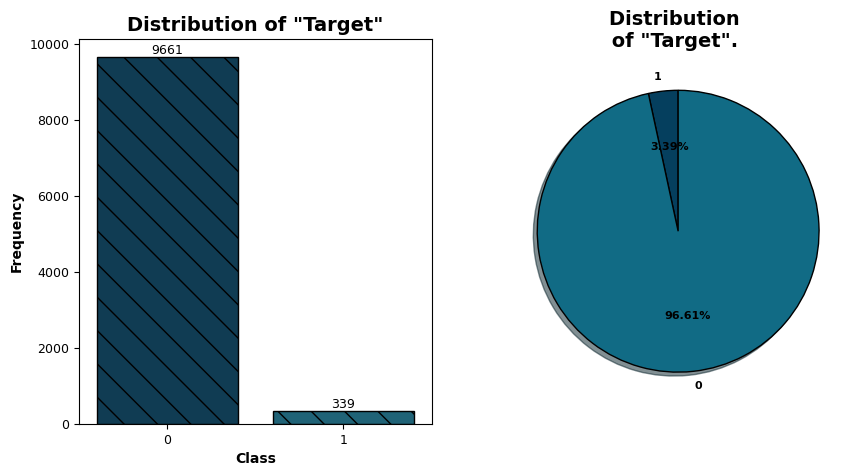

In [34]:
show_category_distribution(df,
                        "Target",
                        colors,
                        bg_color=background_color)

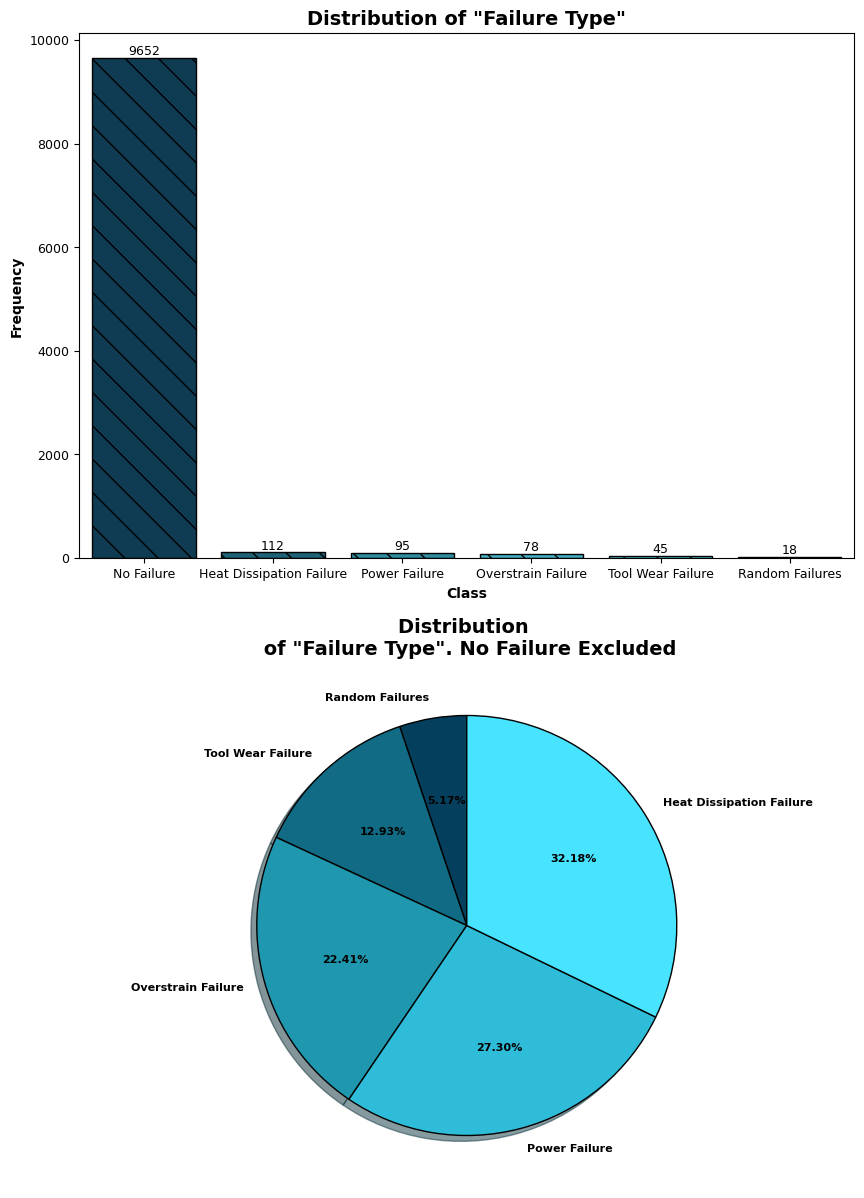

In [35]:
show_category_distribution(df,
                        "Failure Type",
                        colors,
                        exclude=["No Failure"],
                        figsize=(10, 15),
                        d=[2, 1],
                        bg_color=background_color)

In [36]:
def show_outliers(data_frame, exclude=[]):
    columns_list = list(data_frame.columns)
    
    if len(exclude) > 0:
        for e in exclude:
            columns_list.remove(e)

    fig = plt.figure(figsize=(10,30), facecolor=background_color)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for index, column in enumerate(columns_list):
        ax = fig.add_subplot(12, 3, index +1)
        ax = sns.boxplot(x=df[column],
                         notch=True,
                         flierprops={"marker": "x"},
                         boxprops={"facecolor": (.4, .6, .8, .5)},
                         medianprops={"color": "#C34A36"})

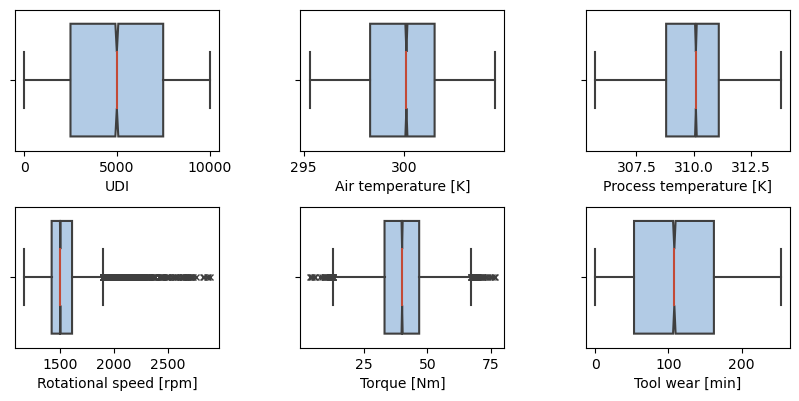

In [37]:
show_outliers(df, exclude=["Failure Type", "Type", "Target", "Product ID"])

### In the next cells, a ficticious dataset will be created in order to test the drift for our project:

In [8]:
df_cleaned = pd.read_csv('/Users/LuisFernandes/mlops-project/data/03_engineered/engineered_data.csv')

In [9]:
df_drift_test = df_cleaned[df_cleaned['Rotational speed [rpm]']>2000.000000]

In [10]:
df_drift_test.head()

,Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Air temperature [C],Process temperature [C],is_low_quality,is_medium_quality,is_high_quality,temp_difference,normalized_torque,low_speed,medium_speed,high_speed
14,2035,19.6,40,0,25.45,36.05,1,0,0,-10.6,0.255875,0,0,1
50,2861,4.6,143,1,25.75,35.95,1,0,0,-10.2,0.060052,0,0,1
194,2678,10.7,86,1,25.05,35.35,0,1,0,-10.3,0.139687,0,0,1
284,2051,19.2,90,0,25.05,35.15,1,0,0,-10.1,0.250653,0,0,1
298,2129,18.7,126,0,24.75,35.35,0,0,1,-10.6,0.244125,0,0,1


In [11]:
df_drift_test.to_csv('/Users/LuisFernandes/mlops-project/data/04_model_input/df_drift_test.csv', index=False)